In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  #

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


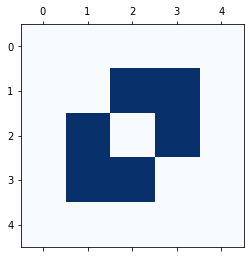

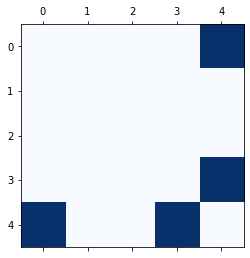

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

# 2. MC SAMPLER

## 2.1.2 Z,B and H Sampling Tests

In [7]:
from samplers import MC_sample_H
from samplers import MC_sample_B
from samplers import MC_sample_Z
from transformation_functions import update_Theta

In [8]:
Z_copy = random_initial_data.Z.copy()
E_copy = random_initial_data.E.copy()
C_copy = random_initial_data.C.copy()
B_copy = random_initial_data.B.copy()
H_copy = random_initial_data.H.copy()
Theta_copy=random_initial_data.Theta.copy()

alpha = np.ones(V)
step_size = 2
W_copy=test_data.W.copy()
Sigma_copy = test_data.Sigma.copy()
K_copy = test_data.K.copy()
G_copy=test_data.G.copy()

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy, debug=True)
B_sample = MC_sample_B(alpha, C_copy)
H_sample, step_size = MC_sample_H(E_copy, Sigma_copy, K_copy, step_size=step_size,
                                 adaptive_step_ratio=1.5, adaptive_step_threshold=0.55, max_step=2)
Theta_sample=update_Theta(Theta_copy,H_sample)


In [9]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
step_size = 0.25
steps = []

for i in range(10000):
    H_sample_old=H_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_sample, B_sample, E_sample, C_sample)
    B_sample = MC_sample_B(alpha, C_sample)
    H_sample, step_size = MC_sample_H(E=E_sample, Sigma=Sigma_copy, K=K_copy, H_current=H_sample_old, step_size=step_size,
                                 adaptive_step_ratio=1.5, adaptive_step_threshold=0.55, max_step=0.25)
    Theta_sample=update_Theta(Theta_copy,H_sample)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix
        steps.append(step_size)

Wall time: 7min 25s


Matrix changes (1 = changed, 0 = same)
count    10000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64


<AxesSubplot:>

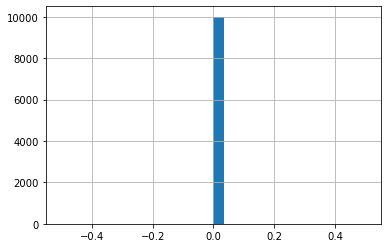

In [10]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    9000.000000
mean       91.616883
std         1.939878
min        84.296351
25%        90.247458
50%        91.674125
75%        92.932547
max        97.613154
dtype: float64


<AxesSubplot:>

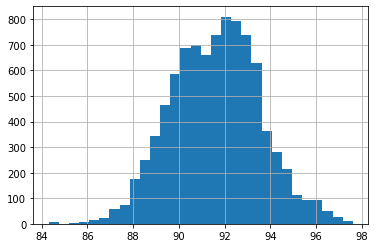

In [11]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


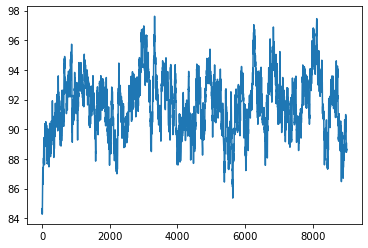

In [12]:
errors.plot()
print("H L2-error series")

Steps
count    9000.000000
mean        0.183413
std         0.061637
min         0.032922
25%         0.111111
50%         0.166667
75%         0.250000
max         0.250000
dtype: float64


<AxesSubplot:>

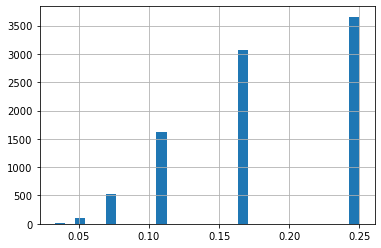

In [13]:
# Matrix should change
steps = pd.Series(steps)
print("Steps")

print(steps.describe())
steps.hist(bins=30)

Steps


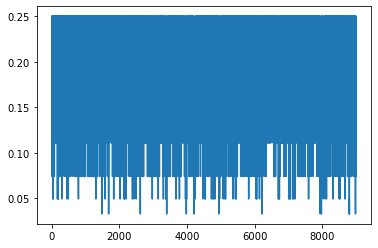

In [14]:
steps.plot()
print("Steps")

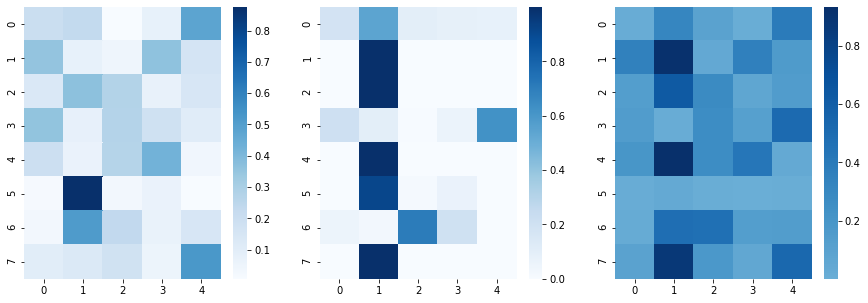

2.2468085390714068

In [15]:
import seaborn as sn
from transformation_functions import update_Theta


fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = update_Theta(np.zeros(H_sample.shape), H_sample)
true_Theta = update_Theta(np.zeros(H_sample.shape), test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta - last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)

In [16]:
np.random.randint(1,4)

1